<a href="https://colab.research.google.com/github/vkatiyar/Hands_on_training/blob/main/Hands_On_training_on_Surface_water_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 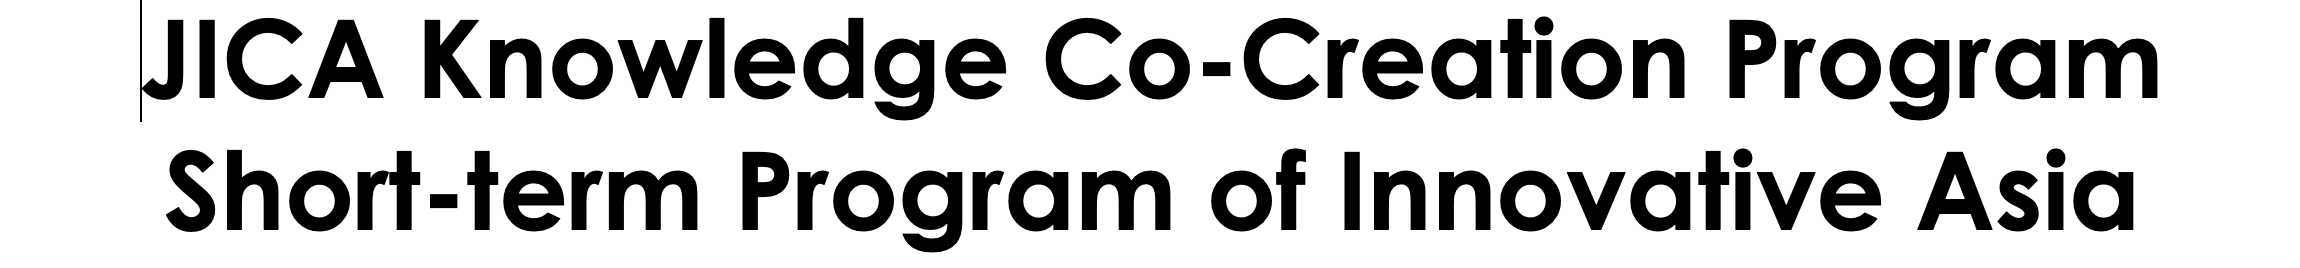






In this Hands-on training, we will learn about the whole pipeline for image segmentation.



**Author**: Vaibhav Katiyar 

***Email-ID***: (<vkatiyar.it@gmail.com>), (<vkatiyar@yamaguchi-u.ac.jp>)

***LinkedIn***: (https://www.linkedin.com/in/vaibhavkatiyar/)

# Have fun with the Neural network

[let the fun begins](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.04275&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

# Prepare the system

In [ ]:
import tensorflow as tf
# checking the GPU availibility
if (len(tf.config.list_physical_devices('GPU'))):
  print("Total available GPU's are =",len(tf.config.list_physical_devices('GPU')))
else:
  print("No GPU is available.")

In [ ]:
# install rasterio. Library to work with satellite image files. 
!pip3 install rasterio

# Prepare Data


### Downloading the data from Google Drive

In [ ]:
# provided by turdus-merula at https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = '1136vzY1DMDnBzesG9NAdD0CE0_-rsPW8'  # 1NX02M3SVpP-6fftRUoVaG6OXgD2fLLQF #ship Dataset
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
import zipfile
def unzip_func(file):  
    with zipfile.ZipFile(file, 'r') as zip_f:
        zip_f.extractall()

In [ ]:
unzip_func(destination)

In [ ]:
# If you want to mount whole google drive. 
# Can be helpful in saving intermediate results. So you will not lose them when session gets terminated

# from google.colab import drive

# drive.mount('/content/gdrive')
# ROOT = "/content/gdrive/MyDrive/"

In [ ]:
import os, shutil, glob  #libraraies to intercat with operating system and other file level functions 
import numpy as np  # basic library for operation on arrays, matrices etc. 

In [ ]:
dataset_path = '/content/NWPU-RESISC45_Lakes_Data'


In [ ]:
# Print all the files 
for file in os.walk(dataset_path):
  print(file)

## Read images and json file

In [ ]:
import rasterio 
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

def read_rasterio_image(img_path):
    with rasterio.open(img_path) as f_arr:        
        return(f_arr.read().transpose(1,2,0)) # transpose (CxHxW=>HxWxC)

In [ ]:
temp_im = 'lake_002.jpg'
im_arr = read_rasterio_image(dataset_path + os.sep + temp_im)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im_arr)
plt.show()
print(im_arr.shape)

In [ ]:
import json #importing json library for workinng with .json file
with open(dataset_path+'/labels_0-100.json','r') as f: # opening the json file, 'open' returns the file object. 
  jsonlabeldata = json.load(f) # load function returns json object as a dictionary

In [ ]:
# %rm -rf '/content/NWPU-RESISC45_Lakes_Data/'
jsonlabeldata[temp_im]

In [ ]:
temp_labeldata = jsonlabeldata[temp_im]
x = temp_labeldata['regions']['0']['shape_attributes']['all_points_x']
y = temp_labeldata['regions']['0']['shape_attributes']['all_points_y']

In [ ]:
%matplotlib inline
plt.imshow(im_arr)
plt.plot(x,y,'r')

## Convert the labels from polygon to masks

In [ ]:
'''Read polygan co-ordinates from JSON 
  returns: X = list of coordiate values of 'x' of all the regions.
          Y = list of coordiate values of 'y' of all the regions.
'''
def get_polygon(image,jsonData ):
    regions = jsonData[os.path.basename(image)]['regions'] # listing all the regions
    X = []
    Y = []
    print ('Number of polygons are {} in the file {}'.format(len(regions),image))

    for region_num in regions:
        X.append (regions[region_num]['shape_attributes']['all_points_x'])
        Y.append (regions[region_num]['shape_attributes']['all_points_y'])
    return (X,Y)


In [ ]:
tmp_x, tmp_y = get_polygon(temp_im,jsonlabeldata)

In [ ]:
# import some drawing tools from PIL
from PIL import Image, ImageDraw

def createMaskfromLabel(img_width, img_height, coordinates):
    mask = np.zeros((img_height,img_width))
    nx = img_width
    ny = img_height
    X,Y = coordinates
    for x,y in zip(X,Y):
        polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()
        img = Image.new('L', (nx, ny), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        # turn into a numpy array
        m = np.array(img)
        mask = mask + m
        mask = mask + np.array(img)
    return 255*(mask > 0).astype(int)

In [ ]:
tmp_mask = createMaskfromLabel(256,256,[tmp_x,tmp_y])
print(np.unique(tmp_mask))
plt.imshow(tmp_mask, cmap='gray')

## Save the masks in the disk

In [ ]:
import matplotlib.image as mplImage
def write_mask(mask, mask_name, mask_path):
    # mask_rasterioformat = mask.transpose() # convert from WxHxC to CxHxW
    if (os.path.isdir(mask_path)):
        mplImage.imsave(os.path.join(mask_path,mask_name), mask.astype('uint8'))

In [ ]:
print("Writing mask- ...")   
for img in sorted(glob.glob(dataset_path+os.sep+'*[0-9].jpg')):
    img_width,img_height = np.shape(read_rasterio_image(img))[0:2]
    coord = get_polygon(os.path.basename(img),jsonlabeldata)
    mask = createMaskfromLabel(img_width,img_height,coord)
    mask_name = os.path.basename(img).split('.')[0]+'_mask.'+os.path.basename(img).split('.')[1]
    write_mask(mask,mask_name,dataset_path)
print(' Done!')

In [ ]:
im_arr1 = read_rasterio_image(dataset_path + os.sep +'lake_001.jpg')
label_arr1 = read_rasterio_image(dataset_path + os.sep +'lake_001_mask.jpg')

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(im_arr1)
ax[1].imshow((label_arr1>150).astype(float).squeeze(), cmap='gray')
print(np.unique((label_arr1>150).astype(float)))

# Preprocessing and readying the data

In [ ]:
# Some utilities methods

# loading all images from the given directory path
def load_all_images(data_path, img_ext='jpg'):
    return np.array([read_rasterio_image(str(p)) for p in 
                                    sorted(glob.glob(data_path+os.sep+"[a-z,A-Z]*."+img_ext))])

# for better visulaization of image with the masks
def paired_image_and_mask(img, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,)*3, axis=-1)
    return np.concatenate([img, mask], axis = 1)

def show_combined_plots(x, y, batch_size, figsize=(8,8)):
  cols = 2
  if (batch_size%2 == 0):
    rows = batch_size//cols
  else:
    rows = batch_size//cols+1
  fig, axs = plt.subplots(rows, cols, figsize = figsize)
  axs = axs.flatten()
  for i in range (0, batch_size):
    combined = paired_image_and_mask(x[i], y[i])
    axs[i].axis('off')
    axs[i].imshow(combined)

  plt.tight_layout()

## Making train,validation and test set

In [ ]:
train_dir = dataset_path+os.sep+"train"
val_dir = dataset_path+os.sep+"val"
test_dir = dataset_path+os.sep+"test"

# IMG_WIDTH,IMG_HEIGHT = (256,256)


Divide the data into three:
* ***train set***
* ***validataion set***
* ***test set***

The Hierarachy structure will be as follows:

```
    Datase_Path
        \
         test
         |    \
         |     images
         |     |     \
         |     |      -> *.jpg of actual lakes
         |     masks
         |          \
         |            -> *_mask.jpg mask images
         train
         |    \
         |     images
         |     |     \
         |     |      -> *.jpg of actual lakes
         |     masks
         |          \
         |            -> *_mask.jpg mask images
         val
         |    \
         |     images
         |     |     \
         |     |      -> *.jpg of actual lakes
         |     masks
         |          \
         |           -> *_mask.jpg mask images

 ```

In [ ]:
import errno # standard library to check the error type
try:
    os.mkdir(train_dir)
    os.mkdir(train_dir+os.sep+ 'images')
    os.mkdir(train_dir+os.sep+ 'masks')

    os.mkdir(val_dir)
    os.mkdir(val_dir+os.sep+ 'images')
    os.mkdir(val_dir+os.sep+ 'masks')

    os.mkdir(test_dir)
    os.mkdir(test_dir+os.sep+ 'images')
    os.mkdir(test_dir+os.sep+ 'masks')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    print('Directory already existing.')
    pass

In [ ]:
import random 
random.seed (100) # To ensure that everyone have same datasets
def move_images_mask(imgs,foldername):
  for img in imgs:
    imgName = os.path.basename(img)
    maskName = os.path.basename(img).split('.')[0]+'_mask.jpg'
    src = dataset_path+os.sep
    dst = dataset_path+os.sep+foldername+os.sep
    # print("Val Source = {}, destination = {}".format(src,dst))
    shutil.move(src+imgName,dst+'images/'+imgName)
    shutil.move(src+maskName,dst+'masks/'+maskName)
  print('Files moved in "{}".'.format(foldername)) 

all_images = glob.glob(dataset_path+os.sep+'*[0-9].jpg')
val_test = random.sample(all_images,int(0.3*len(all_images)))
test = random.sample(val_test,int(0.3*len(val_test)))
val = [img for img in val_test if img not in test] 

move_images_mask(test,'test')
move_images_mask(val,'val')
move_images_mask(glob.glob(dataset_path+os.sep+'*[0-9].jpg'),'train')

## Reading and normalizing all the datasets.

In [ ]:
train_imgs = load_all_images (train_dir+os.sep+'/images')
train_masks = load_all_images(train_dir+os.sep+'/masks')
val_imgs = load_all_images (val_dir+os.sep+'/images')
val_masks = load_all_images(val_dir+os.sep+'/masks')
test_imgs = load_all_images(test_dir+os.sep+'/images')
test_masks = load_all_images(test_dir+os.sep+'/masks')
print("Number of train images = {}, masks = {}".format(len(train_imgs),len(train_masks)))
print("Shape of 'train_imgs' = {}, 'train_masks' = {}".format(np.shape(train_imgs),np.shape(train_masks)))
print("Shape of 'val_imgs' = {}, 'val_masks' = {}".format(np.shape(val_imgs),np.shape(val_masks)))
print("Shape of 'test_imgs' = {}, 'test_masks' = {}".format(np.shape(test_imgs),np.shape(test_masks)))

In [ ]:
train_imgs = train_imgs/255.
test_imgs = test_imgs/255.
val_imgs = val_imgs/255.
train_masks = (train_masks[:,:,:,0:1]>150).astype(float)
test_masks = (test_masks[:,:,:,0:1]>150).astype(float)
val_masks = (val_masks[:,:,:,0:1]>150).astype(float)
print("Shape of 'train_imgs' = {}, 'train_masks' = {}".format(np.shape(train_imgs),np.shape(train_masks)))
print("Shape of 'val_imgs' = {}, 'val_masks' = {}".format(np.shape(val_imgs),np.shape(val_masks)))
print("Shape of 'test_imgs' = {}, 'test_masks' = {}".format(np.shape(test_imgs),np.shape(test_masks)))

In [ ]:
print(np.unique(val_masks))

# Build the model

Here we will be building one of the very famous network architecure used for segmentation- [UNet](https://arxiv.org/pdf/1505.04597.pdf). It has been build for the medical imaging segmentation and have shown a great result with lesser amount of training data.

**More materials on UNet:**
* [Deep Learning for Image Segmentation: U-Net Architecture](https://heartbeat.fritz.ai/deep-learning-for-image-segmentation-u-net-architecture-ff17f6e4c1cf)

* [Implementation of deep learning framework -- Unet, using Keras](https://github.com/zhixuhao/unet) by the author of the orginal paper

***More on CNN:***
* [Convolutional Neural Networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

In [ ]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = (256,256,3) # Training images shape

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

In [ ]:
# Build U-Net model
def UNet(filters = 8, input_size = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    conv1 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs) #256x256x8
    conv1 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)  #256x256x8
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)                                                         #128x128x8
    
    conv2 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1) #128x128x16
    conv2 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2) #128x128x16
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)                                                         #64x64x16
    
    #WRITE CODE BY YOURSELF BY TAKING HELP FROM ABOVE
    #START 

    conv4 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3) #32x32x64
    conv4 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4) #32x32x64
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)                                                         #16x16x64

    conv5 = Conv2D(filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4) #16x16x128
    conv5 = Conv2D(filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5) #16x16x128
    up6 = Conv2DTranspose(filters*16, 2, strides=(2, 2), padding='same') (conv5)                                  #32x32x128
    
    merge6 = concatenate([conv4,up6], axis = 3)                                                            #32x32x192
    conv6 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6) #32x32x64
    conv6 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)  #32x32x64
    up7 = Conv2DTranspose(filters*8, 2, strides=(2, 2), padding='same') (conv6)                                   #64x64x64

    #WRITE CODE BY YOURSELF BY TAKING HELP FROM ABOVE
    #START                                   

    merge8 = concatenate([conv2,up8], axis = 3)                                                            #128x128x48
    conv8 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8) #128x128x16
    conv8 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)  #128x128x16
    up9 = Conv2DTranspose(filters*2, 2, strides=(2, 2), padding='same') (conv8)                                   #256x256x16
    
    merge9 = concatenate([conv1,up9], axis = 3)                                                            #256x256x24
    conv9 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)  #256x256x8
    conv9 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)   #256x256x8
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)   #256x256x2
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)                                                   #256x256x1

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = UNet(8)
model.summary()

In [ ]:
# Plotting the model. Just for visualization purpose.
tf.keras.utils.plot_model(model, to_file="model_1.png", show_shapes=True)

# **Training**
* Set Hyperparamater
* Compile the model.
* Start training


In [ ]:
BATCH_SIZE = 8
EPOCH = 25


In [ ]:
model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:

result = model.fit(train_imgs,train_masks,
                    batch_size= BATCH_SIZE,
                    validation_data =(val_imgs,val_masks),
                    epochs = EPOCH)


### plot the loss and accuracy

In [ ]:
loss = result.history['loss']
val_loss = result.history['val_loss']
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

epochs = range(EPOCH)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Tuning Hyperparameter

There are few points on the basis of which we can tune our parameters. These are defined below:

* Look at bias (training data performance): for finding the bias, you will look the difference between the training accuracy and human level accuracy. If there is high bias then it indicates the ***underfitting*** problem.
>* In this case we can look for bigger network to get more abstract features or can train longer to better fit the training data.

* Look at Variance (validation data performance): to get the variance we will see the difference among traing set accuracy and validataion set accuracy. High variance indicates that our model is posssibly ***overfitting*** on the training set.
>* In this case we may look for more data or we can also do some regularization to avoid the overfitting problem

More on regularization: (https://towardsdatascience.com/regularization-part-4-2ee8e7aa60ec)



In [ ]:
# Check the above model output and think what is possibly happening and which mechanism to apply.

# Prediction and evalaution

In [ ]:
# returns a model prediction 
def predictor(model, images_for_prediction):
    decoded_images = model.predict(images_for_prediction)
    return decoded_images

In [ ]:
# indexes= np.arange(0,04,2)
predicted_output = predictor(model,test_imgs)

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i].squeeze())
    plt.axis('off')
  plt.show()

In [ ]:
plt.imshow(val_imgs[0],cmap='gray', vmin=0,vmax=1)
# print(train_imgs[9].max())

In [ ]:
for i,im in enumerate(test_imgs):
  pred_im = predictor(model,np.expand_dims(im,axis=0))
  display([im,test_masks[i],pred_im])

# Saving model in the disk and loading from the disk

In [ ]:
# Save the entire model to a HDF5 file.
def savemodel(model,name):
  model.save(name +'.h5')
  print(name +'.h5' + ' saved')

from tensorflow.keras.models import load_model
def loadmodel(modelname):
  model = load_model(modelname)
  return model

In [ ]:
savemodel(model,'Unet_SGD_8f')

# Callback function and their uses
* ***EarlyStopping***: Stop training when the monitored metric has stopped improving for certain time(patience).
* ***ModelCheckPoint***: save a model or weights (in a checkpoint file) at some interval.
* ***TensorBoard***: TensorBoard provides the visualization support, it can visualize the model graph, loss and accuracy during training etc. 

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_callback(modelName):

    # a tolerance for the training.
    min_delta = 0.001

    # minimum learning rate (lambda)
    min_lr = 0.0001

    # the factor applied to the learning rate when the appropriate triggers are made
    factor = 0.8

    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=10,
                                    verbose=1, mode='auto', min_delta=min_delta,
                                    cooldown=5, min_lr=min_lr)

    earlystopper =  EarlyStopping(monitor= 'val_loss', patience = 50, verbose = 1)
    modelName = "unet_"+modelName + ".h5"
    checkpointer = ModelCheckpoint(modelName,verbose = 1, save_best_only=True)
    if (not os.path.exists("logs/")):
        os.mkdir("logs/")
    tensorboard = TensorBoard(log_dir = "logs", histogram_freq=1)
    return [earlystopper, checkpointer,  tensorboard, reduceloss_plat]

def training(model,train_imgs, train_masks, val_imgs, val_masks, modelName=""):
    result = model.fit(train_imgs,train_masks,
              batch_size= BATCH_SIZE,
              validation_data =(val_imgs,val_masks),
              epochs = EPOCH,
              callbacks=[build_callback(modelName)])
    return result

In [ ]:
tf.keras.backend.clear_session()
model = UNet(16)
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
trainingHistory = training(model,train_imgs, train_masks, val_imgs, val_masks,"16f_rmsprop")

# Other accuracy matrices and loss functions

***IoU***: One of the most popular accuracy metric to evaluate the performance of the semantic segmentation is 'Intersection over Union (IoU)'. IoU focuses on the object shape as a whole rather than comparing the pixel level accuracy.

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

Here $y_{true}$ is the label given and $y_{pred}$ is the prediction of the model.

***Soft Dice Loss***: Many time network tends to ignore smaller classes. In this case dice loss can be used to train a model 


More resources:
[Metrics for semantic segmentation](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html) by Angelo Monteux

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    #binarize and make a float
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    # get the intersection (numerator in above equation) 
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    # get the union (denominator)
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    # compute iou as the ratio unless the denominator is zero
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def dice_coef(y_true, y_pred): 
    smooth = 1e-07
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))     
    return (2 * intersection / (union + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Practice

Train your own Unet model with the following paramaters:

* Starting Filters: 16
* loss function: dice_coef
* metrics: mean_iou
* epoch: 50
* batch_size:16

After the training, plot the loss and mean_iou for training and validation and show the plots.

# Using tensorboard to visualize

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard

In [ ]:
# 
%tensorboard --logdir logs

# Image augmentation

In general, more vaiability in data allows the model to generalise better, which means the performance on the unseen set(test set) will be very good. However, many a time we do not have enough data for model to get better trained. In this situation Image augmentation helps.

Image Augmentation means using the available images to create more number of instances by including some changes in them. Some of these changes can be:
* Rotation
* Translatation
* Flip (Horizontal or Vertical)
* Random cropping
* Random brightness/contrast
* Random zoom
* etc.


***More Resources:***
[Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)


## Training using the augmentation through ImageDataGenrator
  



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
SEED = 111
def createTrainGenerator():
    train_data_gen_args = dict(
                        shear_range=0.3,
                        zoom_range=[0.7,1],
                        rotation_range=90,
                        horizontal_flip=True,
                        vertical_flip=True
                              )

    image_datagen = ImageDataGenerator(**train_data_gen_args)
    mask_datagen = ImageDataGenerator(**train_data_gen_args)
    
    image_generator = image_datagen.flow(
        train_imgs,
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False)
    mask_generator = mask_datagen.flow(
        train_masks,
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False)

    train_generator = (pair for pair in zip(image_generator, mask_generator))

    return train_generator

def createValGenerator():
    val_data_gen_args = dict(
                    horizontal_flip=True,
                    vertical_flip=True
                          )
    img_datagen = ImageDataGenerator(**val_data_gen_args)
    mk_datagen = ImageDataGenerator(**val_data_gen_args)

    img_generator = img_datagen.flow(
        val_imgs,
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False)

    mk_generator = mk_datagen.flow(
        val_masks,
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False)
    
    val_generator = (pair for pair in zip(img_generator, mk_generator))
    return val_generator

In [ ]:
train_gen = createTrainGenerator()
val_gen = createValGenerator()

In [ ]:
img,mask = next(train_gen)

In [ ]:
show_combined_plots(img,mask,4,(10,10))

In [ ]:
def training_generator(train_g, val_g, modelName=''):
  steps_per_epoch = len(train_imgs)//BATCH_SIZE
  validation_steps = len(train_imgs)//BATCH_SIZE
  result = model.fit(train_g,
              batch_size= BATCH_SIZE,
              validation_data =val_g,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              epochs = EPOCH,
              callbacks=[build_callback(modelName)])
  return result

In [ ]:
tf.keras.backend.clear_session()
model = UNet(8)
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
train_g_History = training_generator(train_gen,val_gen,"8f_rmsprop_augm")

# More Reading material:

* [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/) by Francois Chollet


* [Semantic Segmentation with Deep Learning](https://towardsdatascience.com/semantic-segmentation-with-deep-learning-a-guide-and-code-e52fc8958823)

* [An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/) by Sebastian Ruder

* [Intersection over union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) by Adrian Rosebrock

* [Optimizers](https://mlfromscratch.com/optimizers-explained/#/) by Casper Hansen

# Transfer learning?

##  What is Transfer Learning?


  - ... Providing a 'prior' knowledge
  - Using experince/knowledge learned from one <b> "set of tasks" </b> for faster learning and better performance on a <b> "new and related task" </b>.
<br>
<br>

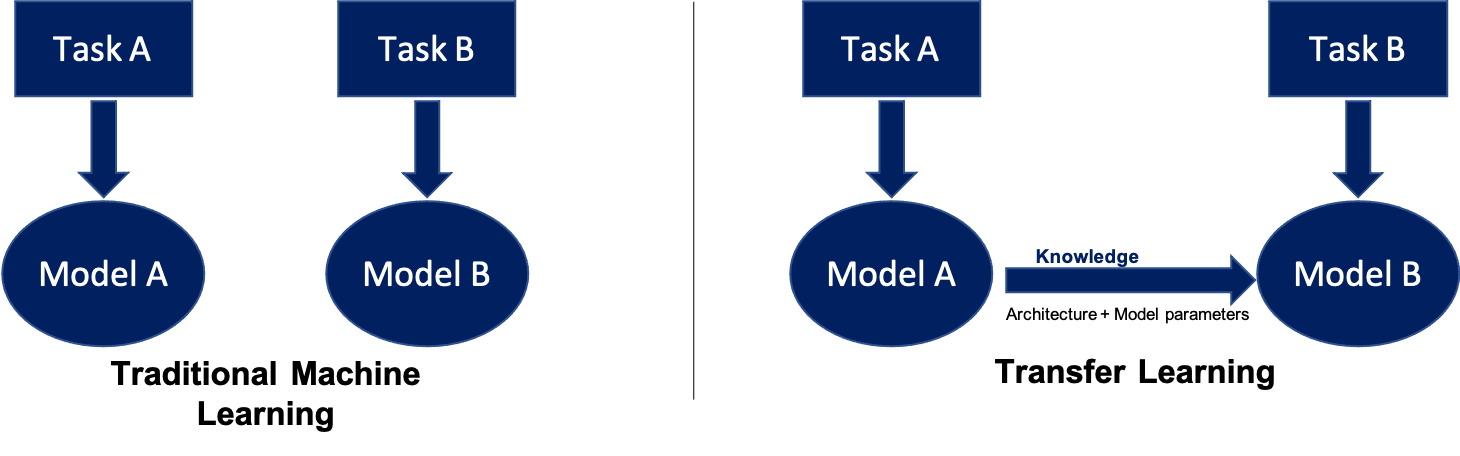




##  Why it is good to use Transfer learning?

  - Fast convergence (less training time)
  - Can use bigger network without overfitting the smaller dataset.
  - Can be used with moderate processing power (less number of the trainiable paramters)

  <br>
  <br>

  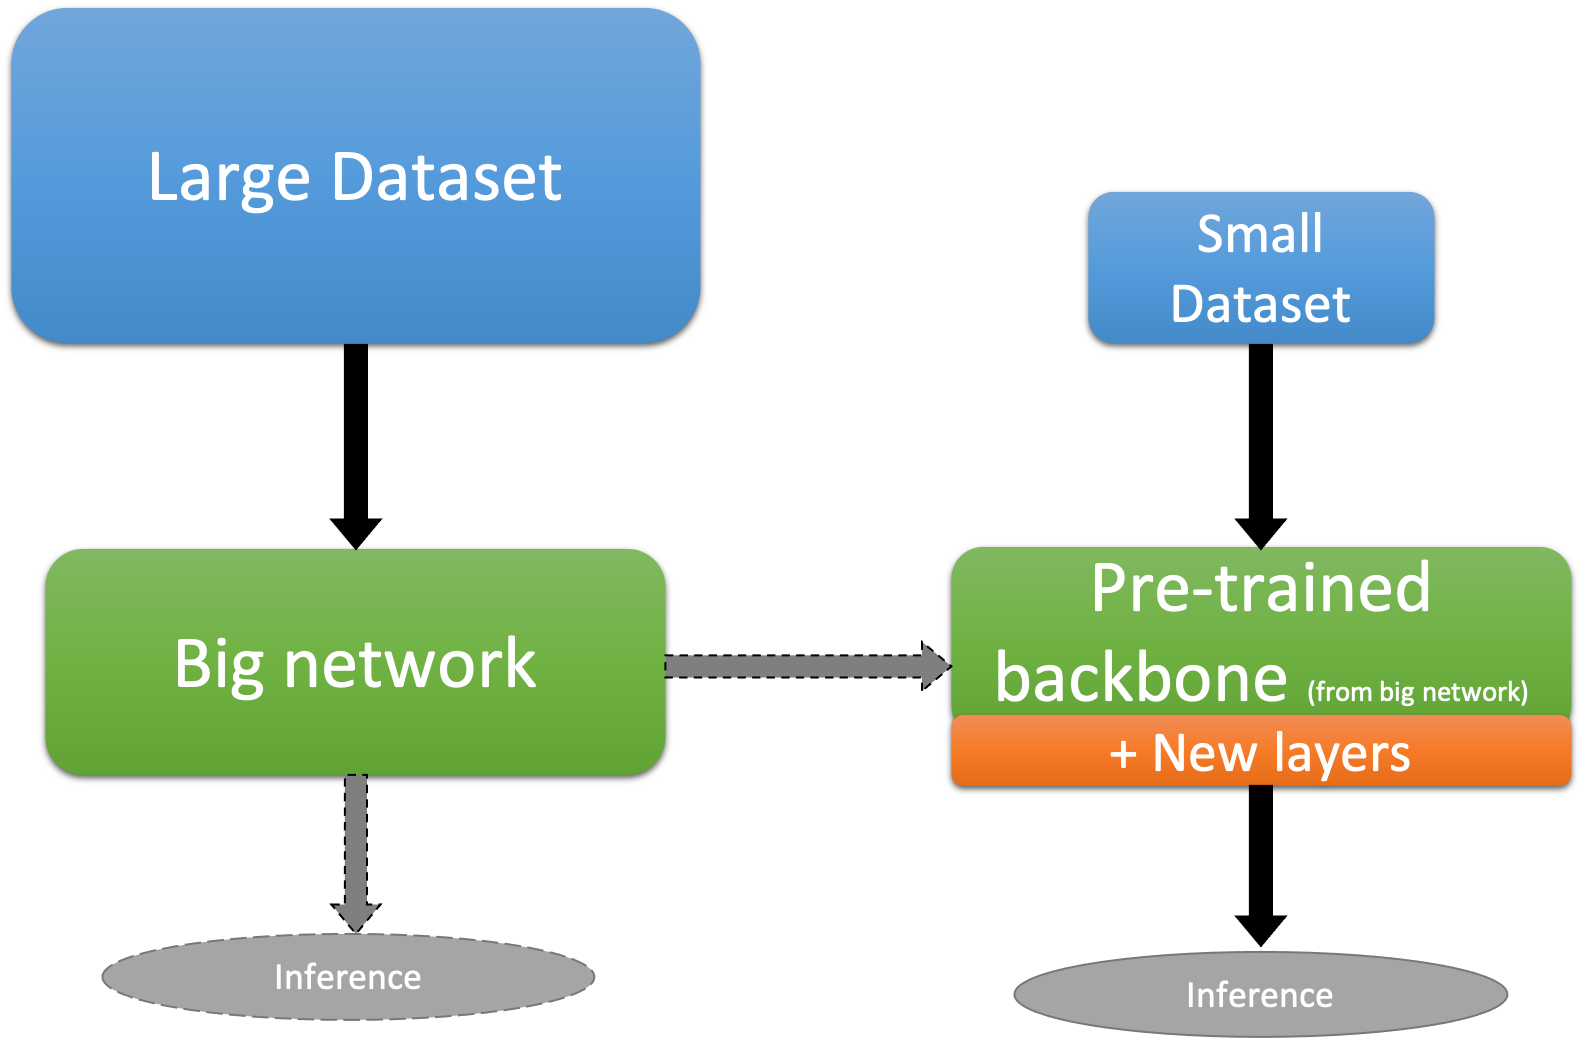 

In [ ]:
from tensorflow.keras.models import load_model

def loadTheModel(modelName):  # loading the previously saved model
    
    model = load_model(modelName)
    # # model.load_weights("res_dice_unet6.h5")
    return(model)

In [ ]:
modelName = 'Unet_SGD_8f.h5'
model_tl = loadTheModel(modelName)

In [ ]:
model_tl.summary()

In [ ]:
print(model_tl.layers.index(model_tl.get_layer('conv2d_transpose_3')))

In [ ]:
# model.trainable = False  #Whole model can be made as trainable or untrainable

for layer in model_tl.layers[0:20]:
#     print(layer.name)
    layer.trainable = False  #certain layers can be frozen.

model_tl.summary()


